# Clustering ATMs

In this notebook, I will pick n atm ids (n=50) and generate a dataset for clustering.

In [6]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from models import *

import pickle
import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

In [8]:
df['AtmId'].value_counts()[:50].index

Int64Index([ 26637,  27687,  27663,  33817,  33821,  27651,  32785,  33793,
             33795,  33796, 119852,  33800,  27664,  27667,  33807,  33850,
             33774,  33852,  27711,  33827,  33828,  33830,  27707,  33831,
             33833,  27727,  27723,  33879,  27714,  33862,  33809,  33771,
             27729,  27570,  27537,  33677,  27539,  33679,  33713,  33714,
             27556,  33724,  33726,  27579,  33707,  27568,  33711, 119801,
             33766,  33750],
           dtype='int64')

## Generating Datasets with Data of All ATMs

In [9]:
def get_clustering_df(all_atms_feature_set, clustering_feature, target):
    clustering_df = pd.DataFrame(columns=all_atms_feature_set[clustering_feature].unique(), dtype='float64')

    for atm_id in all_atms_feature_set['AtmId'].unique():
        atm_df = all_atms_feature_set[all_atms_feature_set['AtmId'] == atm_id]
        clustering_df.loc[atm_id] = atm_df.groupby(clustering_feature).mean()[target]

    clustering_df = clustering_df.divide(clustering_df.sum(axis=1), axis = 0)
    return clustering_df

In [10]:
def get_clustering(clustering_df, clustering_alg, n_clusters, random_state = 42):
    fitted_alg = clustering_alg(n_clusters=n_clusters, random_state=random_state).fit(clustering_df)
    return {i:label for i, label in zip(clustering_df.index, fitted_alg.labels_)}


In [11]:
def get_all_atms_feature_set(df, atm_ids=None, first_n=None):
    assert atm_ids != None or (atm_ids == None and first_n != None), "You must provide atm_ids or first_n parameter"
    
    if atm_ids == None:
        atm_ids = df['AtmId'].value_counts()[:first_n].index

    feature_sets = []

    for atm_id in atm_ids:
        atm_df = get_atm(df, atm_id)
        atm_df = atm_df[:-135]
        atm_df = clean_data(atm_df, drop_zeros=True)
            
        day_of_the_week_index = get_day_of_the_week_index(atm_df.index)

        atm_df['AtmId'] = atm_id
        feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])
        feature_sets.append(feature_set)

    return pd.concat(feature_sets, axis=0)

In [12]:
all_atms_feature_set = get_all_atms_feature_set(df, first_n = 800)
all_atms_feature_set

,CashIn,CashOut,AtmId,CashIn_average_7,CashIn_std_7,CashIn_average_14,CashIn_std_14,CashIn_average_30,CashIn_std_30,CashOut_average_7,...,is_ramazan,ramazan_in_7_days,is_kurban,kurban_in_7_days,is_cocuk_bayrami,is_isci_bayrami,is_spor_bayrami,is_zafer_bayrami,is_cumhuriyet_bayrami,Special_Lunar_Dates_Index
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-01-31,7870.0,26760.0,26637,48987.142857,26801.456872,59583.571429,33667.710760,47928.333333,30126.510846,36631.428571,...,0,0,0,0,0,0,0,0,0,0
2016-02-01,77470.0,50950.0,26637,46801.428571,29722.499014,56777.857143,36316.115342,48153.000000,29788.718548,38345.714286,...,0,0,0,0,0,0,0,0,0,0
2016-02-02,48640.0,56910.0,26637,56868.571429,25650.008726,52136.428571,27640.594062,49862.000000,29956.057864,34768.571429,...,0,0,0,0,0,0,0,0,0,0
2016-02-03,95250.0,46090.0,26637,54272.857143,25394.392238,51025.714286,27430.606913,51060.333333,29125.325096,39551.428571,...,0,0,0,0,0,0,0,0,0,0
2016-02-04,31680.0,69560.0,26637,57701.428571,29376.487440,55592.857143,29163.664808,54087.000000,28831.038369,41568.571429,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-18,121775.0,83030.0,28845,90445.000000,25796.953632,87684.642857,23366.458823,90800.166667,23343.563814,72017.142857,...,0,0,0,0,0,0,0,0,0,0
2020-01-19,61570.0,41540.0,28845,94673.571429,28420.377624,90627.500000,24943.394204,90940.833333,23522.375814,75748.571429,...,0,0,0,0,0,0,0,0,0,0
2020-01-20,159395.0,91930.0,28845,93022.142857,30163.271382,91729.285714,23099.947291,90173.166667,24105.031006,75355.714286,...,0,0,0,0,0,0,0,0,0,0


## Applying Kmeans and Updating the Dataset

In [13]:
def add_cluster_features(all_atms_feature_set, feature_cluster_pairs, target, clustering_alg):
    all_atms_feature_set = all_atms_feature_set.copy()

    for feature, n_clusters in feature_cluster_pairs:
        clustering_df = get_clustering_df(all_atms_feature_set, feature, target)
        d = get_clustering(clustering_df, clustering_alg, n_clusters)

        file = open(f"{feature}_cluster_pickle", 'ab')
        pickle.dump(d, file)
        file.close()

        all_atms_feature_set[feature + '_ClusterId'] = all_atms_feature_set['AtmId'].map(d)
    
    return all_atms_feature_set

In [15]:
all_atms_feature_set = add_cluster_features(all_atms_feature_set, [('Day_of_the_Week_Index', 20), ('Special_Lunar_Dates_Index', 20), ('Month_of_the_Year_Index', 20)], 'CashIn', KMeans)
all_atms_feature_set.sort_index(inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000234B0360648>,
      dtype=object)

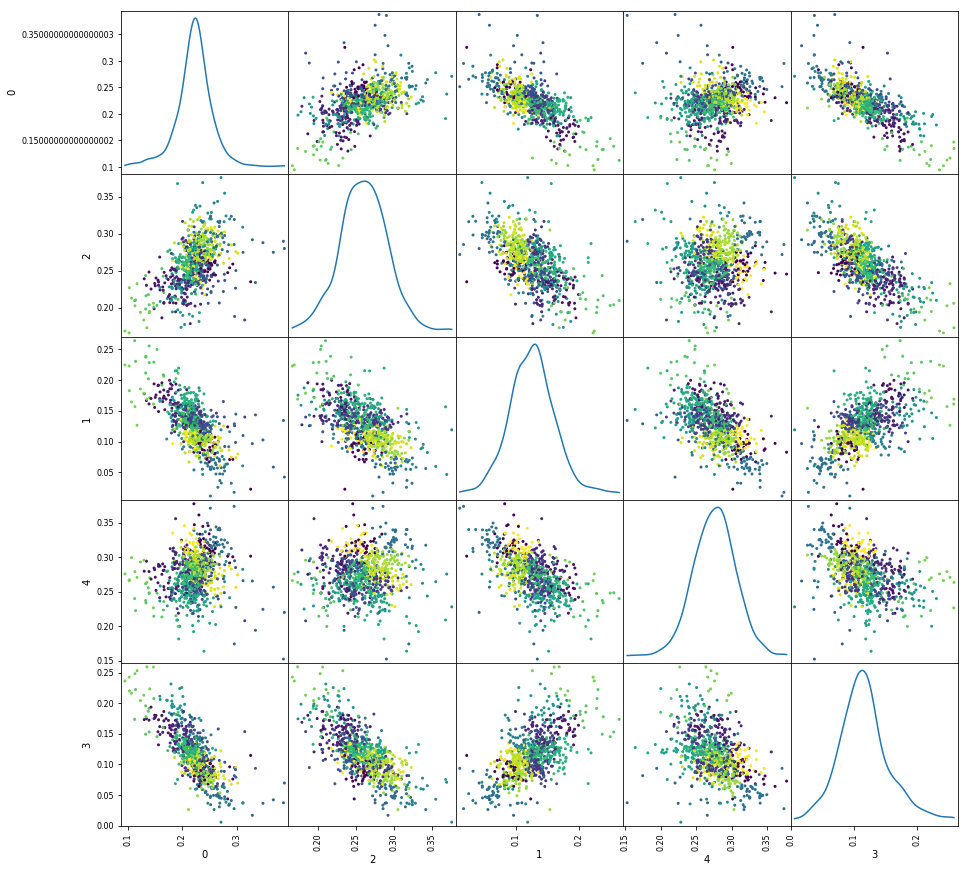

In [18]:
from pandas.plotting import scatter_matrix

clustering_df = get_clustering_df(all_atms_feature_set, 'Special_Lunar_Dates_Index', 'CashIn')
d = get_clustering(clustering_df, KMeans, 20)
scatter_matrix(clustering_df, alpha=1, figsize=(15, 15), c=list(d.values()), diagonal="kde")

## Aranging Data for Model Training

In [ ]:
all_atms_feature_set.columns

Index(['CashIn', 'CashOut', 'AtmId', 'CashIn_average_7', 'CashIn_std_7',
       'CashIn_average_14', 'CashIn_std_14', 'CashIn_average_30',
       'CashIn_std_30', 'CashOut_average_7', 'CashOut_std_7',
       'CashOut_average_14', 'CashOut_std_14', 'CashOut_average_30',
       'CashOut_std_30', 'CashIn_trend_7', 'CashOut_trend_7', 'CashIn_t-1',
       'CashIn_t-2', 'CashIn_t-3', 'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6',
       'CashIn_t-7', 'CashIn_t-8', 'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11',
       'CashIn_t-12', 'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1',
       'CashOut_t-2', 'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5',
       'CashOut_t-6', 'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9',
       'CashOut_t-10', 'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13',
       'CashOut_t-14', 'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17',
       'CashOut_t-18', 'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21',
       'CashOut_t-22', 'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25',
       'CashO

In [ ]:
categorical_features = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Is_Weekday', 'Special_Dates_Index',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami', 'ClusterId']
continuous_features   = ['CashIn_average_7', 'CashIn_std_7',
       'CashIn_average_14', 'CashIn_std_14', 'CashIn_average_30',
       'CashIn_std_30', 'CashOut_average_7', 'CashOut_std_7',
       'CashOut_average_14', 'CashOut_std_14', 'CashOut_average_30',
       'CashOut_std_30', 'CashIn_trend_7', 'CashOut_trend_7',
        'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37', 'CashOut_t-38',
       'CashOut_t-39', 'CashOut_t-40']

groups = [continuous_features]
groups.extend(categorical_features)

TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(all_atms_feature_set[all_atms_feature_set.columns[2:]], all_atms_feature_set[TARGET], shuffle = False)

train_inputs = get_input_sets(X_train, groups)
test_inputs  = get_input_sets(X_test, groups)

## Training

In [ ]:
tabTransformer = TabTransformer(
    categories = [len(all_atms_feature_set[categorical].unique()) for categorical in categorical_features],
    num_continuous = len(continuous_features),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 12,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden = [(128, 'relu'), (32, 'relu')],
    normalize_continuous = False
)

In [ ]:
tabTransformer.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse',
    metrics='mape')

In [ ]:
history = tabTransformer.fit(train_inputs, 
            y_train,
            batch_size=1024,
            epochs=5,
            validation_data=(test_inputs, y_test),
            verbose = 1)

Epoch 1/5
22/22 [==============================] - 58s 2s/step - loss: 8214930096172.5215 - mape: 6410.7444 - val_loss: 597243264.0000 - val_mape: 61.9278
Epoch 2/5
22/22 [==============================] - 49s 2s/step - loss: 616615955.4783 - mape: 182.3712 - val_loss: 506055136.0000 - val_mape: 63.0836
Epoch 3/5
22/22 [==============================] - 49s 2s/step - loss: 474348011.1304 - mape: 150.0245 - val_loss: 477124736.0000 - val_mape: 61.0455
Epoch 4/5
22/22 [==============================] - 48s 2s/step - loss: 415961314.7826 - mape: 127.3155 - val_loss: 467587840.0000 - val_mape: 59.7437
Epoch 5/5
22/22 [==============================] - 48s 2s/step - loss: 402029028.1739 - mape: 200.7890 - val_loss: 463770016.0000 - val_mape: 64.0901


In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        if key[-4:] == 'loss':
            continue
        plt.plot(history.history[key][:], label = key)
    plt.legend()
    plt.show()

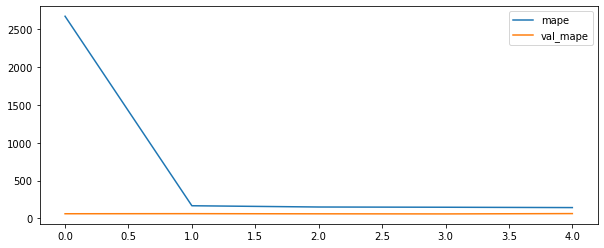

In [ ]:
plot_history(history)

In [ ]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['mape']), min(history.history['val_mape']))

'min_loss: 143.5003, min_val_loss: 59.7437'

In [ ]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [ ]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [ ]:
ATM_ID = 33821
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
draw_model_error(tabTransformer, get_input_sets(atm_feature_set, groups), atm_feature_set[TARGET], split_from=X_train.index[-1])

67.22565872120117
